# Predict pitch parameter

In [9]:
import numpy as np
import h5py
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import SGD, Adadelta
from keras.callbacks import EarlyStopping

In [10]:
hidden_layers = 6

## Keras model
* DNN with simple tanh activations, and sigmoid for the last

In [11]:
nlayers=1024
model = Sequential()
model.add(Dense(nlayers, input_dim=215, activation='tanh', init = 'glorot_normal'))
model.add(Dropout(0.5))
for i in range(0,hidden_layers):
    model.add(Dense(nlayers, activation='tanh',init = 'glorot_normal'))
    model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()        

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_2 (Dense)                  (None, 1024)          221184      dense_input_2[0][0]              
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 1024)          0           dense_2[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 1024)          1049600     dropout_2[0][0]                  
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 1024)          0           dense_3[0][0]                    
___________________________________________________________________________________________

### Early stopping and optimizer

In [12]:
early_stopping = EarlyStopping(patience=8)

In [13]:
model.compile(optimizer=SGD(lr=0.1, momentum=0.75, nesterov=False), loss='mse', metrics=['accuracy'])

### Import train and validation data

In [3]:
data = []
with h5py.File('preprocessed_data/train-standardized.h5','r') as hf:
    data = np.array(hf.get('dataset'))
input_data = data[:,0:215]
print(input_data.shape)
target_data = data[:,215:216]
target_data = target_data
print(target_data.shape)

(216559, 215)
(216559, 1)


In [16]:
maxs = np.max(target_data, axis=0)
mins = np.min(target_data, axis=0)
target_data = (target_data-mins)/(maxs-mins)

Validation data

In [4]:
data_validation = []
with h5py.File('preprocessed_data/validation.h5','r') as hf:
    data_validation = np.array(hf.get('dataset'))
input_validation = data_validation[:,0:215]
print(input_validation.shape)
target_validation = data_validation[:,215:216]
target_validation = target_validation
print(target_validation.shape)

(12594, 215)
(12594, 1)


In [5]:
mean = []
with h5py.File('preprocessed_data/train-mean.h5') as hf:
    mean = np.array(hf.get('dataset'))
sdt = []
with h5py.File('preprocessed_data/train-mean.h5') as hf:
    std = np.array(hf.get('dataset'))

In [10]:
input_validation2 = (input_validation-mean[0:215])/(std[0:215])

In [11]:
target_validation = (target_validation-mins)/(maxs-mins)

## Train

In [31]:
model.fit(input_data, target_data, nb_epoch=1000, 
          validation_data=(input_validation2, target_validation),batch_size=512, verbose=1,
         callbacks=[early_stopping])

Train on 216559 samples, validate on 12594 samples
Epoch 1/1000
216559/216559 [==============================] - 9s - loss: 0.0473 - acc: 0.4421 - val_loss: 0.0752 - val_acc: 0.3978
Epoch 2/1000
216559/216559 [==============================] - 8s - loss: 0.0382 - acc: 0.4477 - val_loss: 0.0783 - val_acc: 0.3884
Epoch 3/1000
216559/216559 [==============================] - 8s - loss: 0.0360 - acc: 0.4480 - val_loss: 0.0738 - val_acc: 0.3831
Epoch 4/1000
216559/216559 [==============================] - 8s - loss: 0.0346 - acc: 0.4485 - val_loss: 0.0565 - val_acc: 0.3865
Epoch 5/1000
216559/216559 [==============================] - 8s - loss: 0.0337 - acc: 0.4487 - val_loss: 0.0685 - val_acc: 0.3769
Epoch 6/1000
216559/216559 [==============================] - 8s - loss: 0.0331 - acc: 0.4487 - val_loss: 0.0607 - val_acc: 0.3789
Epoch 7/1000
216559/216559 [==============================] - 9s - loss: 0.0328 - acc: 0.4487 - val_loss: 0.0571 - val_acc: 0.3818
Epoch 8/1000
216559/216559 [====

In [18]:
model.save('models_data/model_pitch.h5')
model.save_weights('models_data/model_pitch_weights.h5')

h5f = h5py.File('models_data/max_min_pitch.h5', 'w')
h5f.create_dataset('dataset',data=[maxs,mins])
h5f.close()

## Evaulation

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

### Import test data

In [15]:
data_test = []
with h5py.File('preprocessed_data/test.h5','r') as hf:
    data_test = np.array(hf.get('dataset'))
    
#Using example test sentence
#import generate_training_set as gt
#data_test = gt.generate_sentence_data(["arctic_a0348","Get down and dig in."])
#data_test = np.array(data_test)
    
input_test = data_test[:,0:215]
print(input_test.shape)
target_test = data_test[:,215:216]
print(target_test.shape)

(12249, 215)
(12249, 1)


In [19]:
target_test2 = (target_test-mins)/(maxs-mins)

In [20]:
input_test2 = (input_test-mean[0:215])/(std[0:215])

In [32]:
output_test = []
for test in input_test2:
    test = np.array(test)
    test = test.reshape(1,215)
    output_test.append(model.predict(test).reshape(1))
output_test= np.asarray(output_test)

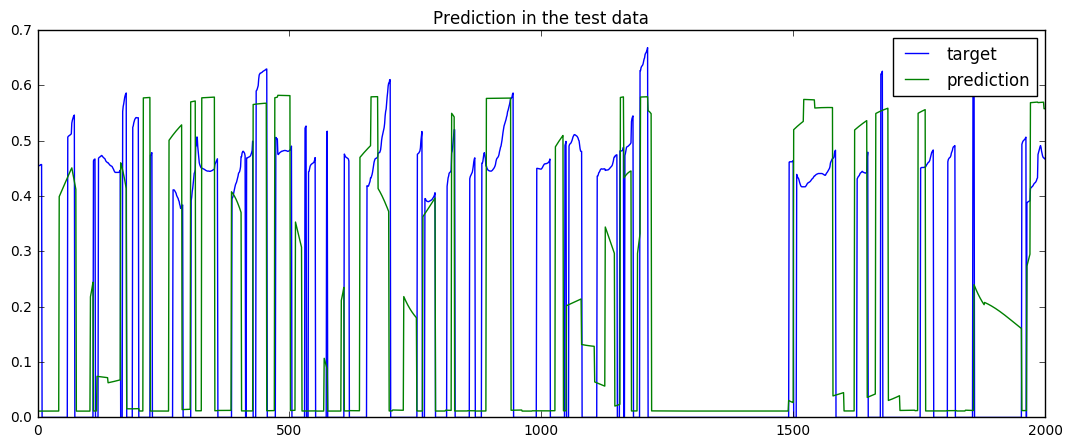

In [36]:
plt.figure(figsize=(13,5))
plt.title('Prediction in the test data')
plt.plot(target_test2[500:2500], label='target')
plt.plot(output_test[500:2500], label='prediction')
plt.legend()
plt.show()

In [44]:
maxs

array([ 266.66666667])